# Chapter 3: Least Mean Square

## Imports 

In [1]:
import os, sys
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
sources_path = './../Sources'
if sources_path not in sys.path:
    sys.path.append(sources_path)
from adaptive_filtering.lms import LMS
from adaptive_filtering.utils import rolling_window, generate_learning_plots

j = complex(0,1)

## Exercise 2

### (a) Compute de Wiener Solution

$x(k) = -0.85x(k-1)+n(k) = -ax(k-1)+n(k)$

Assuming x(k) is WSS and according to example 2.4.b,

$r(l) = \frac{(-a)^{|l|}}{1-a^2}$ 

Therefore, 

$r(0) = \frac{(-0.85)^{|0|}}{1-(0.85)^2}\sigma_n^2$

$r(1) = \frac{(-0.85)^{|1|}}{1-(0.85)^2}\sigma_n^2$

Since $N = 2$ (first-order filter), 

$ R = 
\begin{bmatrix} 
r(0) & r(1) \\
r(1) & r(0) 
\end{bmatrix} 
= 
\begin{bmatrix} 
1.08 & -0.92 \\
-0.92 & 1.08
\end{bmatrix} \rightarrow R^{-1} = 
\begin{bmatrix} 
    3.33 & 2.83 \\
    2.83 & 3.33
\end{bmatrix}
$

Assuming the desired signal is $d(k) = \textbf{x}(k+L)$

$p = \begin{bmatrix} 
    E[d(k)\textbf{x}[k]\\
    E[d(k)\textbf{x}[k-1]
\end{bmatrix} = 
\begin{bmatrix} 
    E[x(k+L)\textbf{x}(k)\\
    E[x(k+L)\textbf{x}(k-1)
\end{bmatrix} = 
\begin{bmatrix} 
    r(L) \\
    r(L+1)
\end{bmatrix} 
$

For $L = 1$ 

$\textbf{p} = [-0.92, 0.78]^T$
    
Finally, the Wiener solution is 

$\textbf{w}_o = \textbf{R}^{-1}\textbf{p} = [-0.85, 0]^T$

In [6]:
output_filepath = './Outputs/Exercise_2/'
N = 2               # Number of coefficients of the adaptive filter     
L = 1 # Future lag
sigma_n2 = .3      # noise power
r = lambda l, a: ((-a)**(abs(l))/(1-(a)**2))*sigma_n2
R = [[r(0, 0.85), r(1, 0.85)], [r(1, 0.85), r(0, 0.85)]]
print ('R: ', R)
print ('R_inv: ', np.linalg.inv(R))
p = [r(0+L, 0.85), r(1+L, 0.85)]
print ('p: ', p)
w_o = np.dot(np.linalg.inv(R), p)
print ('w_o: ', w_o)

R:  [[1.0810810810810807, -0.9189189189189185], [-0.9189189189189185, 1.0810810810810807]]
R_inv:  [[3.33333333 2.83333333]
 [2.83333333 3.33333333]]
p:  [-0.9189189189189185, 0.7810810810810808]
w_o:  [-0.85  0.  ]


### (b) Choose an appropriate value for $\mu$ and plot the convergence path for the LMS algorithm on the MSE error surface.

In order to satisfy both convergence and low variance on steady-state, 

$0 < \mu < \frac{1}{tr[R]} = 1.85$

By making $\mu = 0.99\frac{1}{tr[R]}$ we have

In [7]:
print ('tr[R] = ', 1/np.trace(R))
mu = 0.99*1/np.trace(R) # Convergence factor (step) (0 < mu < 1)
print ('mu = ', mu)

tr[R] =  0.4625000000000002
mu =  0.45787500000000014


In [12]:
K = 100             # number of iterations (signal length)

def run_problem_2():
    d = np.zeros([K]) # Desired signal
    x = np.zeros([K+L])

    n = np.sqrt(sigma_n2/2)*(np.random.normal(size=K+L)) # Noise signal
    for k in np.arange(1, K):
        x[k] = -0.85*x[k-1] + n[k]

    prefixed_x = np.append(np.zeros([N-1]), x)
    X_tapped = rolling_window(prefixed_x, N)    

    for k in np.arange(K):        
        d[k] = np.dot(np.conj(w_o), X_tapped[k])

    init_coef = np.ones([N]) 
    filter_order = N-1    

    lms = LMS(step=mu, filter_order=filter_order, init_coef=init_coef)
    lms.fit(d, x[:k+1])    

    return lms

lms = run_problem_2()

print (lms)

LMS(step=0.45787500000000014, filter_order=1)


Plotting MSE Error Surface

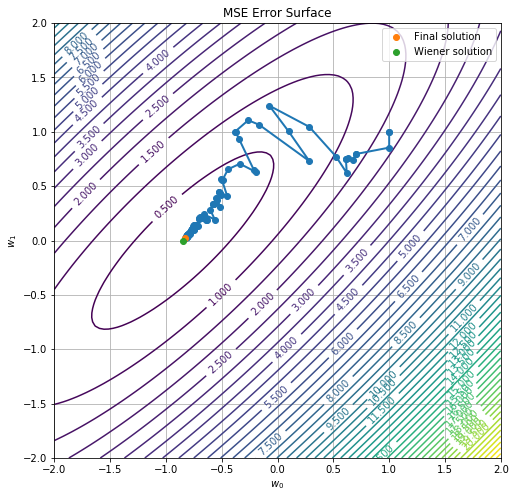

In [13]:
def get_mse_error(w, p, R):
    return R[0][0]-2*np.dot(w,p)+np.dot(np.matmul(w,R), w)

w_0, w_1 = np.linspace(-2,2,100), np.linspace(-2,2,100)
MSE_error = np.zeros([w_0.shape[0], w_1.shape[0]])

for i, w_i in enumerate(w_0):
    for j, w_j in enumerate(w_1):
        MSE_error[i][j] = get_mse_error([w_j, w_i], p, R)

coef = np.real(lms.coef_vector)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,8))
ax.plot(coef[:,0], coef[:,1], '-o', linewidth=2)
ax.plot(coef[-1,0], coef[-1,1], 'o', label='Final solution')
ax.plot(w_o[0], w_o[1], 'o', label='Wiener solution')
cs = ax.contour(w_0, w_1, MSE_error, levels=np.arange(0, np.max(MSE_error), 0.5))
ax.clabel(cs, cs.levels)
ax.set_xlabel('$w_0$'), ax.set_ylabel('$w_1$'), ax.set_title('MSE Error Surface')
ax.grid(True)
ax.legend()
if output_filepath is not None:
    if not os.path.exists(output_filepath):
        os.makedirs(output_filepath)
    fig.savefig(output_filepath + 'b_convergence_path.jpg', bbox_inches = 'tight')

### (c) Plot the learning curves for the MSE and the iteration coeficients in a single run as well as for the average of 25 runs.

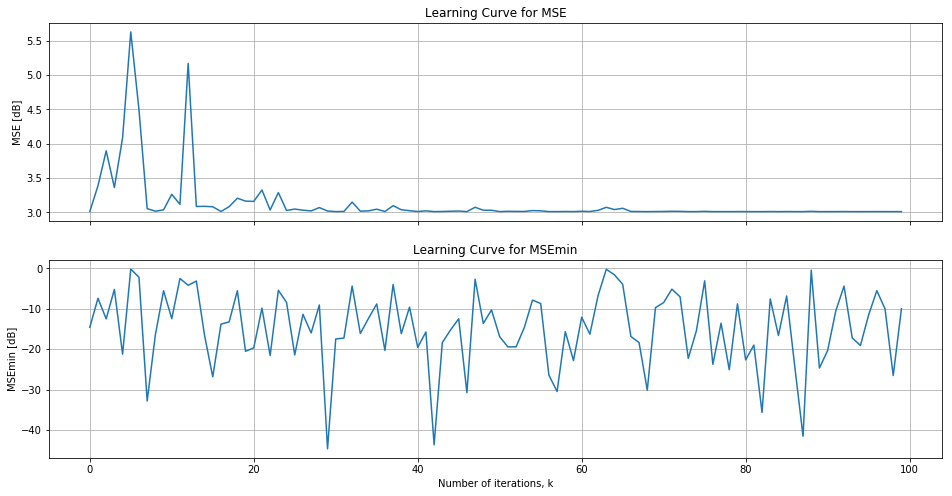

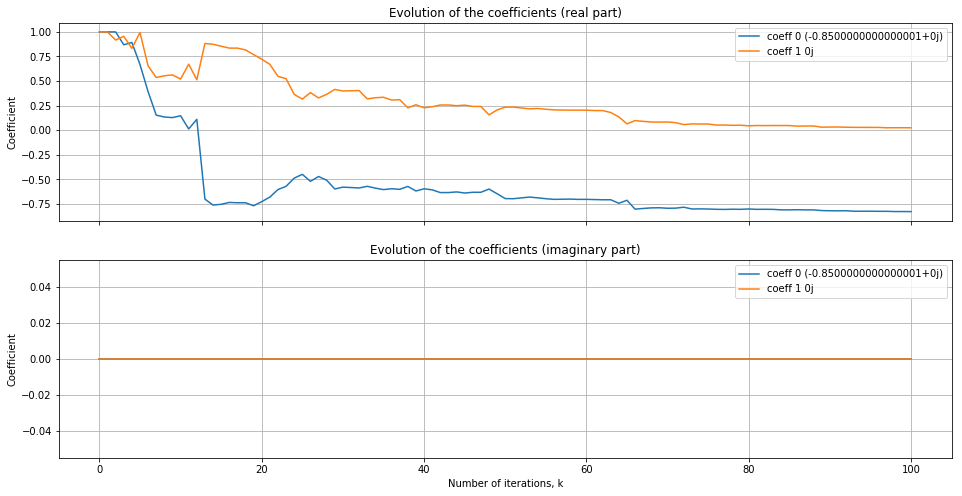

In [32]:
n_ensembles = 1   # number of realizations within the ensemble
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles, K]) # Minimum MSE for each realization 

for ensemble in np.arange(n_ensembles):    
    d = np.zeros([K]) # Desired signal
    x = np.zeros([K+L])

    n = np.sqrt(sigma_n2/2)*(np.random.normal(size=K+L)) # Noise signal
    for k in np.arange(1, K):
        x[k] = -0.85*x[k-1] + n[k]

    prefixed_x = np.append(np.zeros([N-1]), x)
    X_tapped = rolling_window(prefixed_x, N)        
        
    for k in np.arange(K):        
        d[k] = np.dot(np.conj(w_o), X_tapped[k])

    init_coef = np.ones([N])     
    filter_order = N-1    

    lms = LMS(step=mu, filter_order=filter_order, init_coef=init_coef)
    lms.fit(d, x[:k+1])     

    W[ensemble] = np.real(lms.coef_vector)
    MSE[ensemble] = MSE[ensemble] + np.real(np.absolute(lms.error_vector)**2)
    MSE_min[ensemble] = MSE_min[ensemble] + np.real(np.absolute(n[:k+1])**2)
    
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles

# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, w_o, output_filepath=output_filepath, algorithm='LMS_run'+str(n_ensembles))

# Exercise 9

Repeat problem 2 in case the input signal is a uniformly distributed white noise with variance $\sigma_{n_x}^2 = 0.5$ filtered by an all-pole filter given by 

\begin{equation*}
    H(z) = \frac{z}{z-0.9}
\end{equation*}

## (a) Compute the Wiener solution

$x(k) = n_x(k)$

Assuming the input signal is WSS:

\begin{equation*}
    r(l) = E[x(k)x(k-l)] = E[n_x(k)n_x(k-l)] = \sigma_{n_x}^2\delta(l) \\ 
    R = \sigma_{n_x}^2 I_{N\times N}
\end{equation*}

For $H(z)$ we have 

\begin{equation*}
    H(z) = \frac{D(z)}{X(z)} = \frac{z}{z-0.9} \rightarrow d(k) = 0.9d(k-1)+x(k)
\end{equation*}

Consequently

\begin{equation*}
    p(l) = E[d(k)x(k-l)] = E[(0.9d(k-1)+n_x(k))n_x(k-l)] \\
    = E[0.9d(k-1)n_x(k-l)+n_x(k)n_x(k-l)] = 0.9E[d(k-1)n_x(k-l)]+E[n_x(k)n_x(k-l)] \\
    = 0.9p(l-1)+r(l) \\
    = 0.9p(l-1)+\sigma_{n_x}^2\delta(l)
\end{equation*} where $p(-1) = 0$. 

Since N = 2 (first-order filter): 

$ R = 
\begin{bmatrix} 
r(0) & r(1) \\
r(1) & r(0) 
\end{bmatrix} 
= \sigma_{n_x}^2
\begin{bmatrix} 
1 & 0 \\
0 & 1
\end{bmatrix} \rightarrow R^{-1} = \frac{1}{\sigma_{n_x}^2}
\begin{bmatrix} 
    1 & 0 \\
    0 & 1
\end{bmatrix}
$

$ p = 
\begin{bmatrix} 
p(0)\\
p(1)
\end{bmatrix} 
= \sigma_{n_x}^2
\begin{bmatrix} 
1 \\
0.9
\end{bmatrix} 
$

Therefore, the Wiener solution is 

$w_o = R^{-1}p$



In [34]:
output_filepath = './Outputs/Exercise_9/'
N = 2 # Number of coefficients
sigma_n2 = .3 # noise power
sigma_x2 = .5
R = sigma_x2*np.eye(N)
print ('R: ', R)
dirac = lambda l: 1 if l == 0 else 0
p_func = lambda l: 0 if l < 0 else 0.9*p_func(l-1) + sigma_x2*dirac(l)
p = sigma_x2*np.array([p_func(l) for l in np.arange(N)])
print ('p: ', p)
w_o = np.dot(np.linalg.inv(R), p)
print ('w_o: ', w_o)

R:  [[0.5 0. ]
 [0.  0.5]]
p:  [0.25  0.225]
w_o:  [0.5  0.45]


### (b) Choose an appropriate value for $\mu$ and plot the convergence path for the LMS algorithm on the MSE error surface.

In order to satisfy both convergence and low variance on steady-state, 

$0 < \mu < \frac{1}{tr[R]}$

By making $\mu = 0.1\frac{1}{tr[R]}$ we have

In [35]:
mu_max = (1/np.trace(R))
mu = 0.1*mu_max
print ('mu: ', mu)

mu:  0.1


In [36]:
K = 100             # number of iterations (signal length)

def run_problem_9():
    d = np.zeros([K]) # Desired signal        
    x = np.random.uniform(-1, 1, K)
    x = (x-x.mean())/np.sqrt(x.var()/sigma_x2) # Input signal
    n = np.sqrt(sigma_n2/2)*(np.random.normal(size=K)) # Noise signal
    
    prefixed_x = np.append(np.zeros([N-1]), x)
    X_tapped = rolling_window(prefixed_x, N)    

    for k in np.arange(K):
        d[k] = np.dot(np.conj(w_o), X_tapped[k])

    # Fitting algorithm
    lms = LMS(step=mu, filter_order=N-1, init_coef=np.ones([N]))
    lms.fit(d, x)  
    
    return lms

lms = run_problem_9()
print (lms)

LMS(step=0.1, filter_order=1)


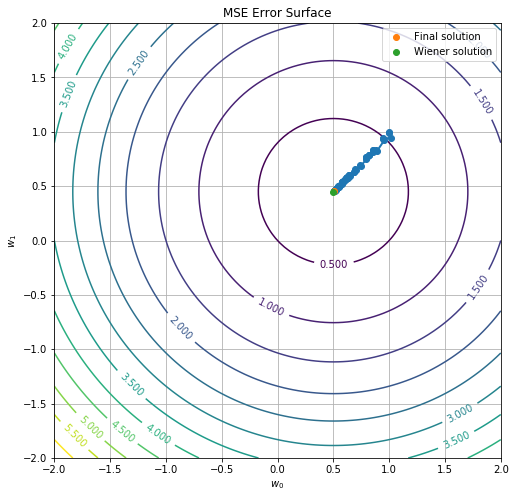

In [37]:
def get_mse_error(w, p, R):
    return R[0][0]-2*np.dot(w,p)+np.dot(np.matmul(w,R), w)

w_0, w_1 = np.linspace(-2,2,100), np.linspace(-2,2,100)
MSE_error = np.zeros([w_0.shape[0], w_1.shape[0]])

for i, w_i in enumerate(w_0):
    for j, w_j in enumerate(w_1):
        MSE_error[i][j] = get_mse_error([w_j, w_i], p, R)

coef = np.real(lms.coef_vector)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,8))
ax.plot(coef[:,0], coef[:,1], '-o', linewidth=2)
ax.plot(coef[-1,0], coef[-1,1], 'o', label='Final solution')
ax.plot(w_o[0], w_o[1], 'o', label='Wiener solution')
cs = ax.contour(w_0, w_1, MSE_error, levels=np.arange(0, np.max(MSE_error), 0.5))
ax.clabel(cs, cs.levels)
ax.set_xlabel('$w_0$'), ax.set_ylabel('$w_1$'), ax.set_title('MSE Error Surface')
ax.grid(True)
ax.legend()
if output_filepath is not None:    
    if not os.path.exists(output_filepath):
        os.makedirs(output_filepath)
    fig.savefig(output_filepath + 'b_convergence_path.jpg', bbox_inches = 'tight')

### (c) Plot the learning curves for the MSE and the iteration coeficients in a single run as well as for the average of 25 runs.

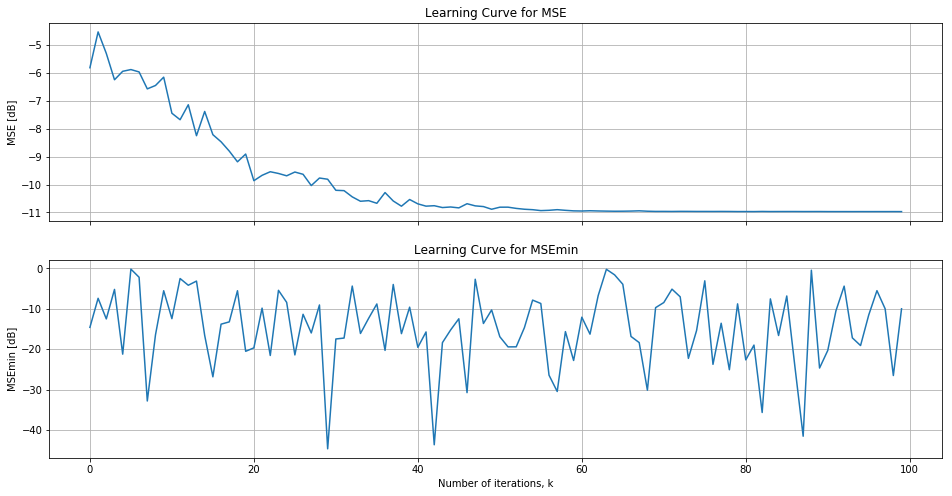

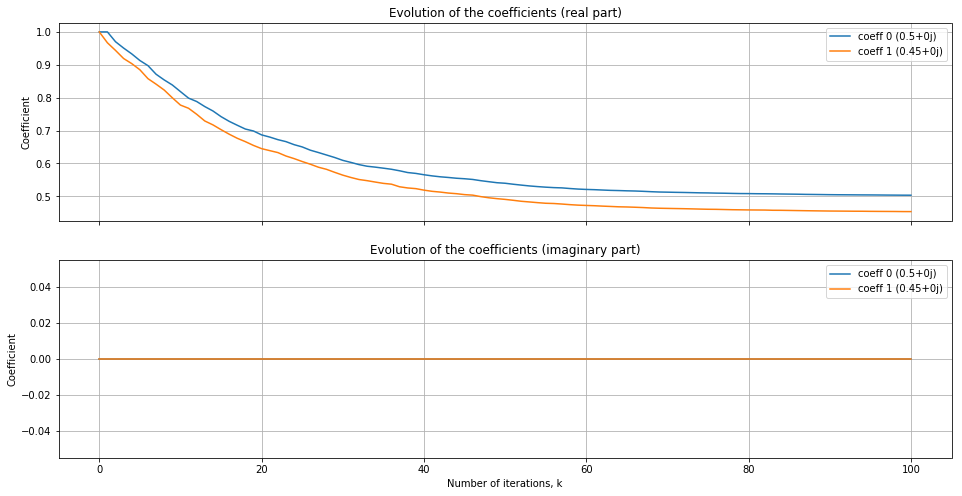

In [41]:
n_ensembles = 25   # number of realizations within the ensemble
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles, K]) # Minimum MSE for each realization 

for ensemble in np.arange(n_ensembles):    
    lms = run_problem_9()         

    W[ensemble] = np.real(lms.coef_vector)
    MSE[ensemble] = MSE[ensemble] + np.real(np.absolute(lms.error_vector)**2)
    MSE_min[ensemble] = MSE_min[ensemble] + np.real(np.absolute(n[:k+1])**2)
    
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles

# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, w_o, output_filepath=output_filepath, algorithm='LMS_run'+str(n_ensembles) )

_________________
## Exercise 7

$x(k) = n_1(k), \sigma_x^2 = 1.0$

$n(k)$ with $\sigma_n^2 = 10^{-3}$

$N = 12$ coefficients


### (a) Calculate the upper bound for $\mu (\mu_{max})$ to guarantee the algorithm stability.

$ r(l) = E[x(k)x(k-l)] = E[n_1(k)n_1(k-l)] = \sigma_x^2 \delta (l)$

$R = \sigma_x^2 I_{N\times N} \rightarrow R^{-1} = \frac{1}{\sigma_x^2} I_{N\times N}$

$0 < \mu < \frac{1}{\lambda_{max}} = \sigma_x^2 = 1$


In [2]:
# output_filepath, N = './Outputs/Exercise_7/', 12
output_filepath, N = './Outputs/Exercise_8/', 8
sigma_x2 = 1
sigma_n2 = 10e-3
R = sigma_x2*np.eye(N)
print ('R: ', R)
mu_max = np.max(np.linalg.eigvals(R))
dirac = lambda l: 1 if l == 0 else 0
p_func = lambda l: 0 if l < 0 else p_func(l-1) + dirac(l)-dirac(l-12)
p = np.array([p_func(l) for l in np.arange(N)])
print ('p: ', p)
w_o = np.dot(np.linalg.inv(R), p)
print ('w_o: ', w_o)
w_o

R:  [[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
p:  [1 1 1 1 1 1 1 1]
w_o:  [1. 1. 1. 1. 1. 1. 1. 1.]


array([1., 1., 1., 1., 1., 1., 1., 1.])

### (b) Run the algorithm for $\mu_{max}/2$, $\mu_{max}/10$  and $\mu_{max}/50$. Comment on the convergence behavior in each case.

$\frac{D(z)}{X{z}} = H(z) = \frac{1-z^{-12}}{1-z^{-1}}$

\begin{equation*}
    d(k) = d(k-1) + x(k) - x(k-12) = d(k-1) + n_1(k) - n_1(k-12) \\
    d'(k) = d(k) + n(k) = d(k-1)+n_1(k) - n_1(k-12) + n(k)
\end{equation*} The scheme is an ARMA process

\begin{equation*}
    p(l) = E[d'(k)x(k-l)] \\    
    = E[(d(k)+n(k))x(k-l)] \\
    = E[d(k)x(k-l) + n(k)x(k-l)] \\
    = E[d(k)n_1(k-l) + n(k)n_1(k-l)] \\
    = E[d(k)n_1(k-l)] + E[n(k)n_1(k-l)]
    = E[(d(k-1)+n_1(k)-n_1(k-12))n_1(k-l)] + 0\\
    = E[d(k-1)n_1(k-l)+n_1(k)n_1(k-l)-n_1(k-12)n_1(k-l)] \\    
    = E[d(k-1)n_1(k-l)]+E[n_1(k)n_1(k-l)]-E[n_1(k-12)n_1(k-l)] \\
    = E[d(k-1)n_1(k-l)] + \sigma_x^2\delta (l) - \sigma_x^2 \delta(l-12) \\
    = p(l-1) + \sigma_x^2\delta (l) - \sigma_x^2 \delta(l-12) 
\end{equation*} with p(-1) = 0




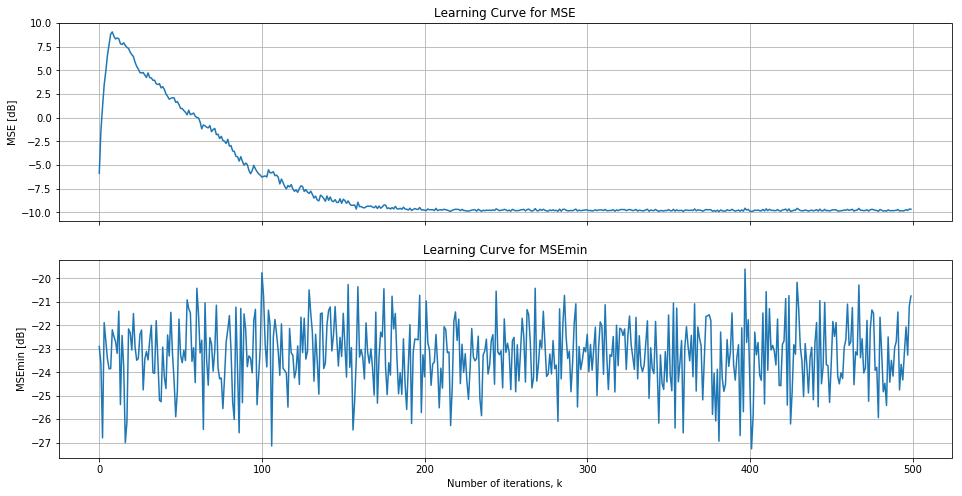

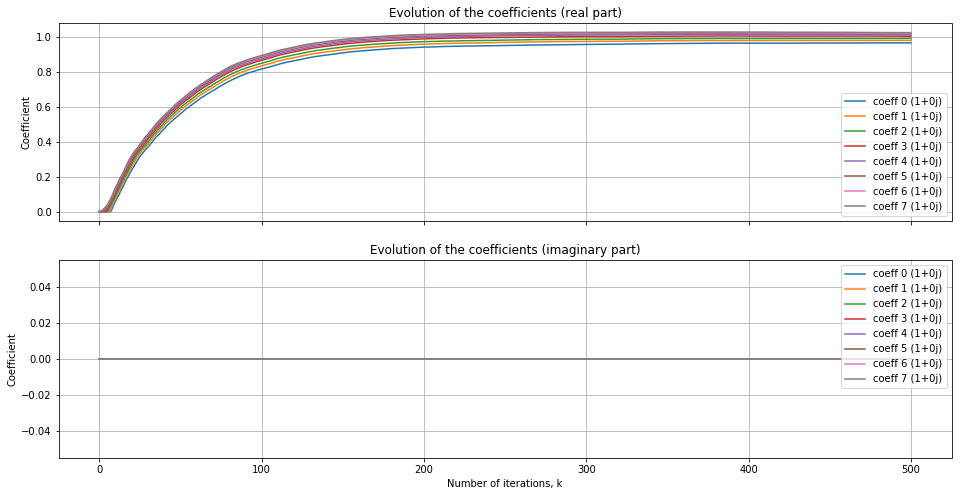

In [10]:
# coefficient vector for each iteration and realization, w[0] = [1, 1, ..., 1]
n_ensembles = 20   # number of realizations within the ensemble
K = 500   # number of iterations (signal length)
W = np.ones([n_ensembles, K+1, N], dtype=complex) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles, K]) # Minimum MSE for each realization 
div = 50
mu = mu_max/div

for ensemble in np.arange(n_ensembles):    
    d = np.zeros([K]) # Desired signal
    n = np.sqrt(sigma_n2/2)*(np.random.normal(size=K)) # Noise signal
    x = np.sqrt(sigma_x2/2)*(np.random.uniform(size=K))
#     x = (np.random.uniform(size=K))
#     x = sigma_x2*(x-x.mean())/np.sqrt(x.var())
    
    prefixed_x = np.append(np.zeros([N-1]), x)
    X_tapped = rolling_window(prefixed_x, N)    

    for k in np.arange(K):        
        d[k] = np.dot(np.conj(w_o), X_tapped[k]) + n[k]

    lms = LMS(step=mu, filter_order=N-1, init_coef=np.zeros([N]))
    lms.fit(d, x)        

    W[ensemble] = lms.coef_vector
    MSE[ensemble] = MSE[ensemble] + np.absolute(lms.error_vector)**2
    MSE_min[ensemble] = MSE_min[ensemble] + np.absolute(n)**2

W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles

# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, w_o, output_filepath=output_filepath, algorithm='LMS_mu_' + str(div)) 
    

### (c) Measure the misadjustment in each example and compare with the results obtained by (3.50).

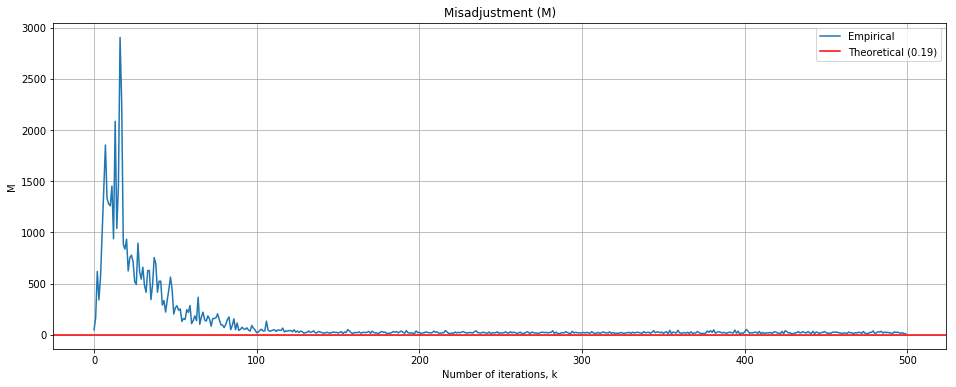

In [11]:
m_theoretical = mu*np.trace(R)/(1-mu*np.trace(R))

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
ax.plot((MSE_av-MSEmin_av)/MSEmin_av, label='Empirical')
ax.axhline(m_theoretical, color='r', label='Theoretical ({:.02f})'.format(m_theoretical))
ax.grid(True)
ax.set_title('Misadjustment (M)'), ax.set_xlabel('Number of iterations, k'), ax.set_ylabel('M')
ax.legend()

if output_filepath is not None:        
    fig.savefig(output_filepath + 'c_misadjustment_mu'+str(div)+'.jpg', bbox_inches = 'tight')

### (d) Plot the obtained FIR filter frequency response at any iteration after convergence is achieved and compare with the unknown system.

C:\Anaconda\lib\site-packages\scipy\signal\filter_design.py:444: RuntimeWarning: divide by zero encountered in true_divide
  npp_polyval(zm1, a, tensor=False))
C:\Anaconda\lib\site-packages\scipy\signal\filter_design.py:444: RuntimeWarning: invalid value encountered in true_divide
  npp_polyval(zm1, a, tensor=False))
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


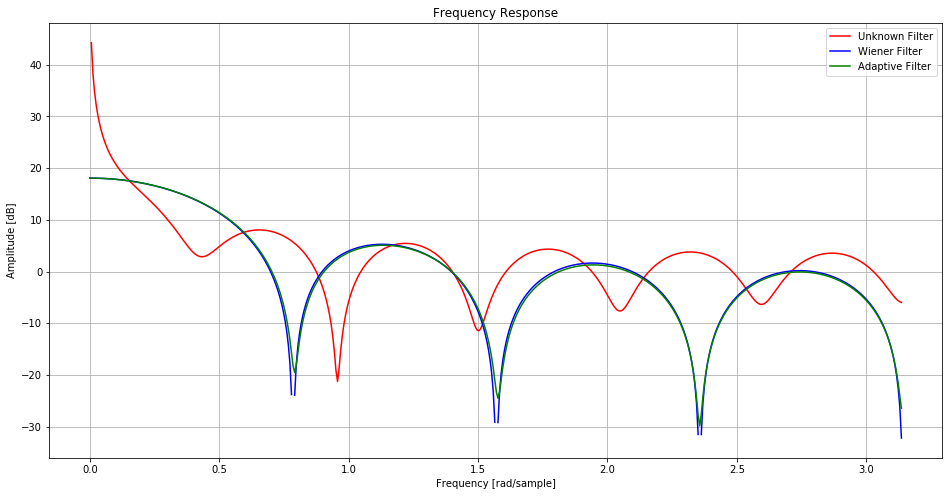

In [12]:
b, a = [1, -1] + list(np.zeros(10)) + [-1], [1, -1]
wf_lms, h_lms = signal.freqz(lms.coef_vector[-1])
wf_o, h_o = signal.freqz(w_o)
wf_unk, h_unk = signal.freqz(b=b, a=a)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,8))

ax.plot(wf_unk, 20 * np.log10(abs(h_unk)), 'r', label='Unknown Filter')
ax.plot(wf_o, 20 * np.log10(abs(h_o)), 'b', label='Wiener Filter')
ax.plot(wf_lms, 20 * np.log10(abs(h_lms)), 'g', label='Adaptive Filter')
ax.set_ylabel('Amplitude [dB]'), ax.set_title('Frequency Response')
ax.set_xlabel('Frequency [rad/sample]')
ax.grid(True)
ax.legend()

if output_filepath is not None:        
    fig.savefig(output_filepath + 'd_frequency_response.jpg', bbox_inches = 'tight')

______________
# Exercise 8

Repeat the previous problem using an adaptive filter with eight coefficients and
interpret the results.

____________________
# Exercise 10

$h(k) = k u(k)-(2k-9)u(k-5) + (k-9)u(k-10)$
\begin{equation*}
    h(k) = k u(k)-(2k-9)u(k-5) + (k-9)u(k-10) \\
    = ku(k)-(2k-10+1)u(k-5)+(k-10+1)u(k-10) \\
    = ku(k)-2(k-5)u(k-5)-u(k-5)+(k-10)u(k-10)+u(k-10)
\end{equation*} Taking the Z transform we have 

\begin{equation*}
    H(z) = \frac{z}{(z-1)^2}-2\frac{z}{(z-1)^2}z^{-5}-\frac{z}{z-1}z^{-5}+\frac{z}{(z-1)^2}z^{-10}+\frac{z}{z-1}z^{-10} \\
    = \frac{z}{(z-1)^2}-2\frac{z}{(z-1)^2}z^{-5}-\frac{z(z-1)}{(z-1)^2}z^{-5}+\frac{z}{(z-1)^2}z^{-10}+\frac{z(z-1)}{(z-1)^2}z^{-10} \\
    = \frac{z}{(z-1)^2}[1-2z^{-5}-(z-1)z^{-5}+z^{-10}+(z-1)z^{-10}] \\
    = \frac{z}{z^2-2z+1}[1-z^{-5}-z^{-4}+z^{-9}] \\
    = \frac{z^{-1}-z^{-6}-z^{-5}+z^{-10}}{1-2z^{-1}+z^{-2}} 
\end{equation*}


$x(k) = sign(n(k))$

$n(k)$ with $\sigma_n = 10^{-2}$

In [59]:
output_filepath = './Outputs/Exercise_10/'
K = 500
N = 100
mu = .1
sigma_n2 = 1e-2

# impulse response function
h_10 = lambda k: k*np.heaviside(k, 1)-(2*k-9)*np.heaviside(k-5, 1)+(k-9)*np.heaviside(k-10, 1)

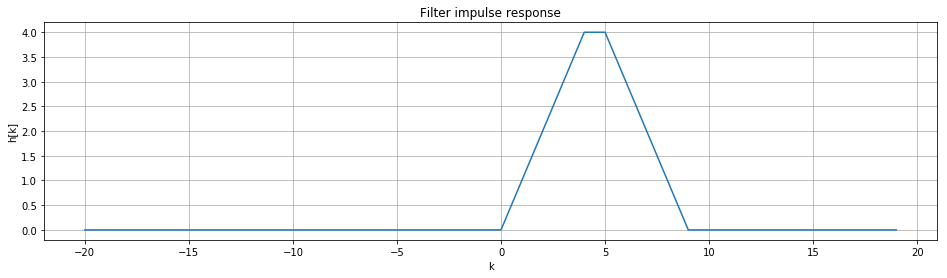

In [90]:
h_length = 20
h = np.zeros(2*h_length)
a = np.arange(-h_length, h_length, 1)
for i, k in enumerate(a):
    h[i] = h_10(k)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
ax.plot(a, h)
ax.grid(True)
ax.set_title('Filter impulse response'), ax.set_xlabel('k'), ax.set_ylabel('h[k]')
if output_filepath is not None:        
    fig.savefig(output_filepath + 'a_unknown_filter_impulse_response.jpg', bbox_inches = 'tight')

In [77]:
# coefficient vector for each iteration and realization, w[0] = [1, 1, ..., 1]
n_ensembles = 25
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles, K]) # Minimum MSE for each realization 
mu = 0.01

for ensemble in np.arange(n_ensembles):    
    d = np.zeros([K]) # Desired signal

    # Creating the input signal (normalized)        
    x = np.sign(np.random.randn(K)) # Input Signal
    n = np.sqrt(sigma_n2/2)*(np.random.normal(size=K)) # Complex noise

    # Convolving h and x
    d = np.convolve(h, x, 'same') + n
    
    init_coef = W[ensemble][0]
    filter_order = N-1    

    lms = LMS(step=mu, filter_order=filter_order, init_coef=init_coef)
    lms.fit(d, x)     

    W[ensemble] = lms.coef_vector
    MSE[ensemble] = MSE[ensemble] + np.absolute(lms.error_vector)**2
    MSE_min[ensemble] = MSE_min[ensemble] + np.absolute(n)**2

W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles


/home/jaoguedes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


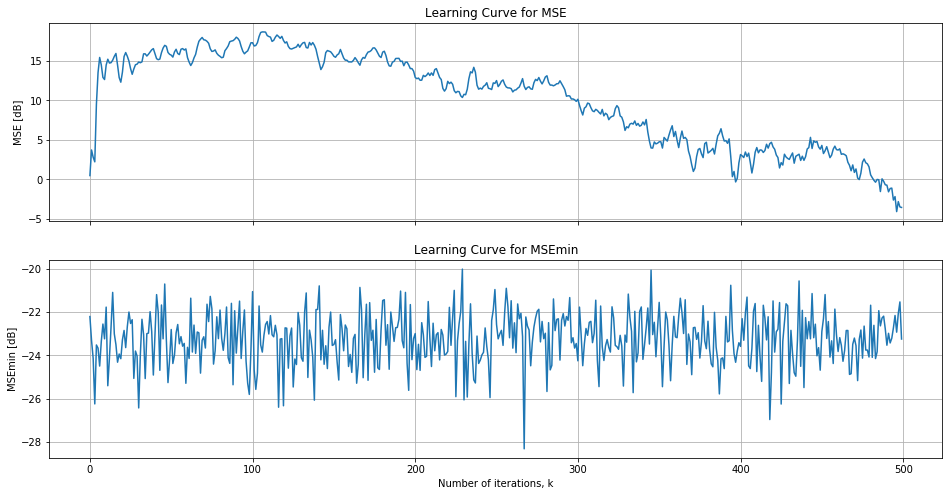

In [89]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16,8), sharex=True)
ax[0].plot(np.arange(K), 10*np.log10(MSE_av))
ax[0].set_title('Learning Curve for MSE')
ax[0].set_ylabel('MSE [dB]')
ax[0].grid(True)

ax[1].plot(np.arange(K), 10*np.log10(MSEmin_av))
ax[1].set_title('Learning Curve for MSEmin')
ax[1].set_ylabel('MSEmin [dB]')
ax[1].set_xlabel('Number of iterations, k') 
ax[1].grid(True)

if output_filepath is not None:        
    fig.savefig(output_filepath + 'a_learning_curve.jpg', bbox_inches = 'tight')

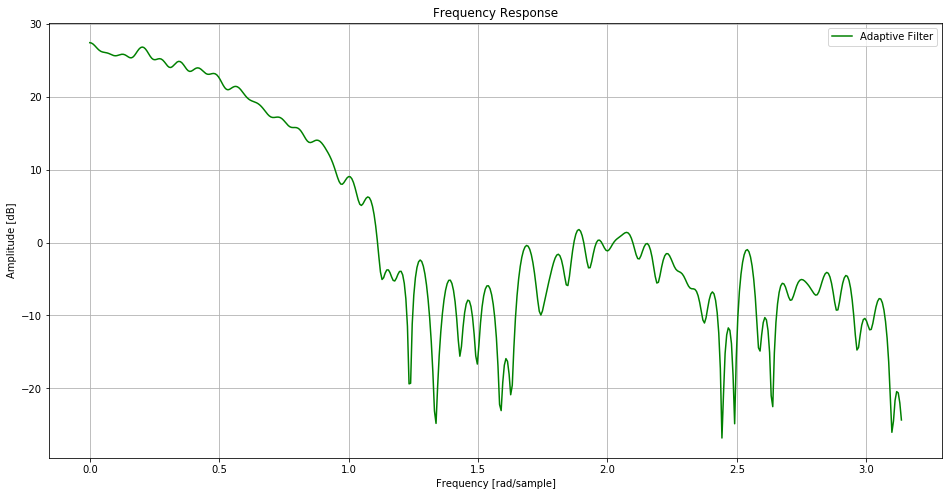

In [88]:
wf_lms, h_lms = signal.freqz(lms.coef_vector[-1])

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,8))

ax.plot(wf_lms, 20 * np.log10(abs(h_lms)), 'g', label='Adaptive Filter')
ax.set_ylabel('Amplitude [dB]'), ax.set_title('Frequency Response')
ax.set_xlabel('Frequency [rad/sample]')
ax.grid(True)
ax.legend()

if output_filepath is not None:        
    fig.savefig(output_filepath + 'a_frequency_response.jpg', bbox_inches = 'tight')

### (b) Convolve one of the equalizer’s impulse response after convergence with the channel impulse response and comment on the result.

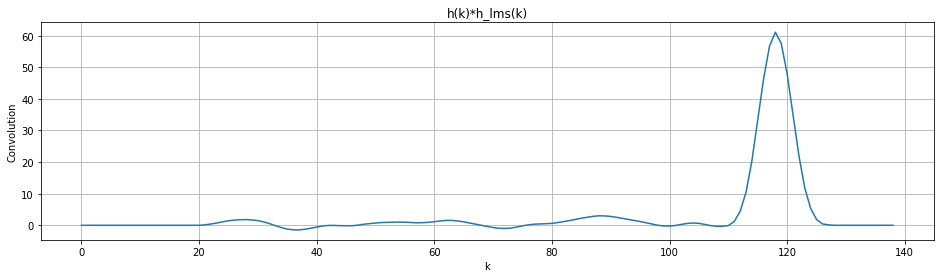

In [87]:
fig, ax = plt.subplots(ncols = 1, nrows=1, figsize=(16,4))
ax.plot(np.convolve(lms.coef_vector[-1], h))
ax.grid(True)
ax.set_title('h(k)*h_lms(k)'), ax.set_xlabel('k'), ax.set_ylabel('Convolution')
if output_filepath is not None:        
    fig.savefig(output_filepath + 'b_convolution.jpg', bbox_inches = 'tight')

# Exercise 15

### (a) For $\mu$ = 0.05 compute the excess MSE

In [28]:
output_filepath = './Outputs/Exercise_15/'
N = 7+1
sigma_x2, sigma_n2, sigma_w2 = .7, .01, .001
lambda_w = .999
mu = .05
R = sigma_x2*np.eye(N)
lambda_r = np.linalg.eigvals(R)
lambda_r
MSE_lag = sigma_w2/(4*mu)*sum([1/(1-mu*lambda_i) for lambda_i in lambda_r])
print ('MSE_lag: ', MSE_lag)
print ('MSE:', MSE)
print ('Total MSE: ', MSE + MSE_lag)

MSE_lag:  0.04145077720207255
MSE: 0.0005932203389830508
Total MSE:  0.042043997541055596


### (b) Repeat (a) for $\mu = 0.01$

In [26]:
mu = 0.01
MSE_lag = sigma_w2/(4*mu)*sum([1/(1-mu*lambda_i) for lambda_i in lambda_r])
MSE = mu*sigma_n2*np.trace(R)/(1-mu*np.trace(R))
print ('MSE_lag:', MSE_lag)
print ('MSE:', MSE)
print ('Total MSE: ', MSE + MSE_lag)

MSE_lag: 0.2014098690835851
MSE: 0.0005932203389830508
Total MSE:  0.20200308942256814


### (c) Compare $\mu_{opt}$ and comment if it can be used.

In [29]:
mu_opt = np.sqrt((N)*sigma_w2/(4*sigma_n2*np.trace(R)))
print ('mu_opt: ', mu_opt)
print ('Stability: 0 < mu < {}'.format(1/np.max(lambda_r)))
print ('Low variance: 0 < mu < {}'.format(1/np.trace(R)))

mu_opt:  0.18898223650461363
Stability: 0 < mu < 1.4285714285714286
Low variance: 0 < mu < 0.17857142857142858


_________________
# Exercise 16

$w_o(k) = \lambda_w w_o(k-1)+n(k)$

where $\lambda_w = 0.999$ and $n$ is a gaussian white noise with $\sigma_w^2 = 0.001$. The initial value for w_o is: 

$w_o[0] = [0.0349, −0.011, −0.06864, 0.22391, 0.55686, 0.35798, −0.0239, −0.07594]^T$

N = 7+1 = 8

$x(k)$ white gaussian with $\sigma_x^2 = 0.7$

$n(k)$ white gaussian with $\sigma_x^2 = 0.01$

$x(k)$ and $n(k)$ independent. 

$d(k) = x^T(k)w_o(k)$

$y(k) = x^T(k)w(k)$

$w(k+1) = w(k) -2\mu e(k)x(k)$


### (a) For $\mu = 0.05$ compute the excess MSE.

In [80]:
output_filepath = './Outputs/Exercise_15/'
K = 100
N = 7+1
sigma_x2, sigma_n2, sigma_w2 = .7, .01, .001
lambda_w = .999
R = sigma_x2*np.eye(N)
mu_opt = np.sqrt((N)*sigma_w2/(4*sigma_n2*np.trace(R)))
mu = .01#mu_opt
print ('mu_opt: ', mu_opt)

mu_opt:  0.18898223650461363


In [81]:
n_ensembles = 25
W = np.zeros([n_ensembles, K+1, N])
W_o = np.zeros([n_ensembles, K+1, N])
MSE = np.zeros([n_ensembles, K])
MSE_min = np.zeros([n_ensembles, K]) # Minimum MSE for each realization 

for ensemble in np.arange(n_ensembles):

    # setting initial w_o
    W_o[ensemble][0] = np.array([0.0349, -0.011, -0.06864, 0.22391, 0.55686, 0.35798, -0.0239, -0.07594])

    n = np.sqrt(sigma_n2/2)*(np.random.normal(size=K)) # Complex noise
    n_w = np.sqrt(sigma_w2/2)*(np.random.normal(size=K)) # Complex noise
    x = np.sqrt(sigma_x2/2)*(np.random.normal(size=K)) # Complex signal
    d = np.zeros(K)
    y = np.zeros(K)
    e = np.zeros(K)

    # Creating a tapped version of x with a N-sized window 
    prefixed_x = np.append(np.zeros([N-1]), x)
    X_tapped = rolling_window(prefixed_x, N)
    for k in np.arange(K):
        d[k] = np.dot(W_o[ensemble][k], X_tapped[k]) + n[k]   
        y[k] = np.dot(W[ensemble][k], X_tapped[k])
        e[k] = d[k]-y[k]
        W[ensemble][k+1] = W[ensemble][k] + mu*e[k]*X_tapped[k]    
        W_o[ensemble][k+1] = lambda_w*W_o[ensemble][k] + n_w[k]
        
    MSE[ensemble] = np.abs(e)**2
    MSE_min[ensemble] = np.abs(n)**2     

W_av = np.sum(W, axis=0)/n_ensembles
W_o_av = np.sum(W_o, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles
MSEexc_av = np.sum(MSE-MSE_min, axis=0)/n_ensembles

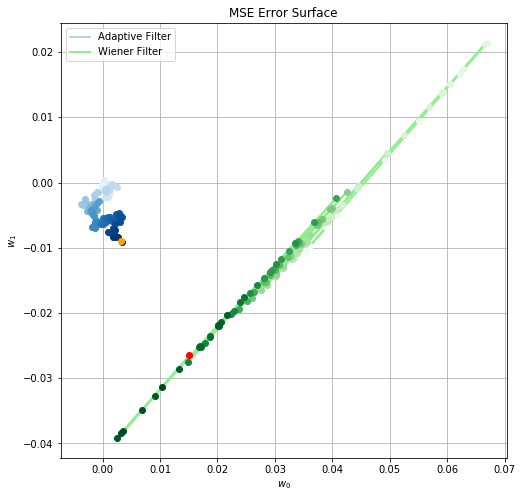

In [82]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_mse_error(w, p, R):
    return R[0][0]-2*np.dot(w,p)+np.dot(np.matmul(w,R), w)

cmap = cm.get_cmap('Blues', K)(np.linspace(0,1,K))[:,:-1]
cmap_o = cm.get_cmap('Greens', K)(np.linspace(0,1,K))[:,:-1]

# w_0, w_1 = np.linspace(-2,2,100), np.linspace(-2,2,100)
# MSE_error = np.zeros([w_0.shape[0], w_1.shape[0]])

# for i, w_i in enumerate(w_0):
#     for j, w_j in enumerate(w_1):
#         MSE_error[i][j] = get_mse_error([w_j, w_i], p, R)

# coef = np.real(lms.coef_vector)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,8))
ax.plot(W_av[:,0], W_av[:,1], '-', linewidth=2, color='lightblue', label='Adaptive Filter')
ax.plot(W_o_av[:,0], W_o_av[:,1], '-', linewidth=2, color='lightgreen', label='Wiener Filter')
for k in np.arange(K):
    c_w = 'orange' if k == K-1 else cmap[k]
    c_w_o = 'red' if k == K-1 else cmap_o[k]
    ax.plot(W_av[k,0], W_av[k,1], 'o', linewidth=2, color=c_w)
    ax.plot(W_o_av[k,0], W_o_av[k,1], 'o', linewidth=2, color=c_w_o)
# cs = ax.contour(w_0, w_1, MSE_error, levels=np.arange(0, np.max(MSE_error), 0.5))
# ax.clabel(cs, cs.levels)
ax.set_xlabel('$w_0$'), ax.set_ylabel('$w_1$'), ax.set_title('MSE Error Surface')
ax.grid(True)
ax.legend()
# if output_filepath is not None:    
#     if not os.path.exists(output_filepath):
#         os.makedirs(output_filepath)
#     fig.savefig(output_filepath + 'b_convergence_path.jpg', bbox_inches = 'tight')

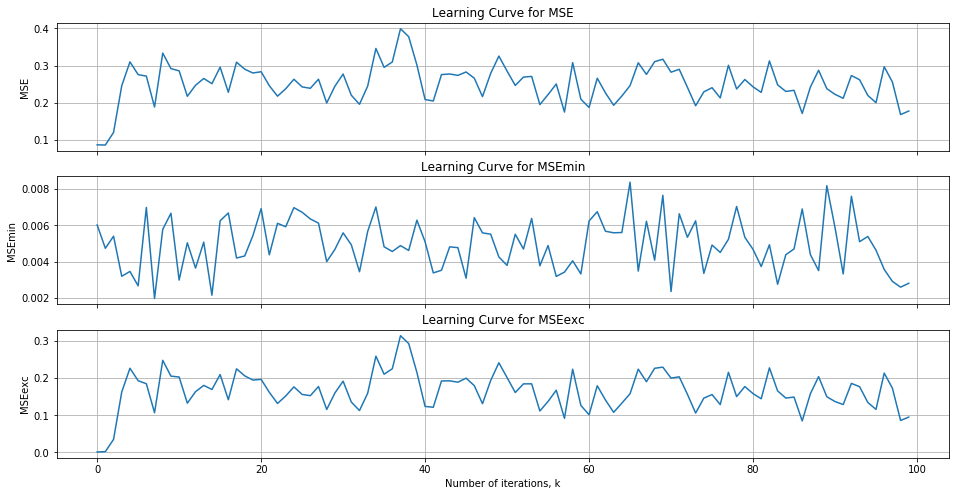

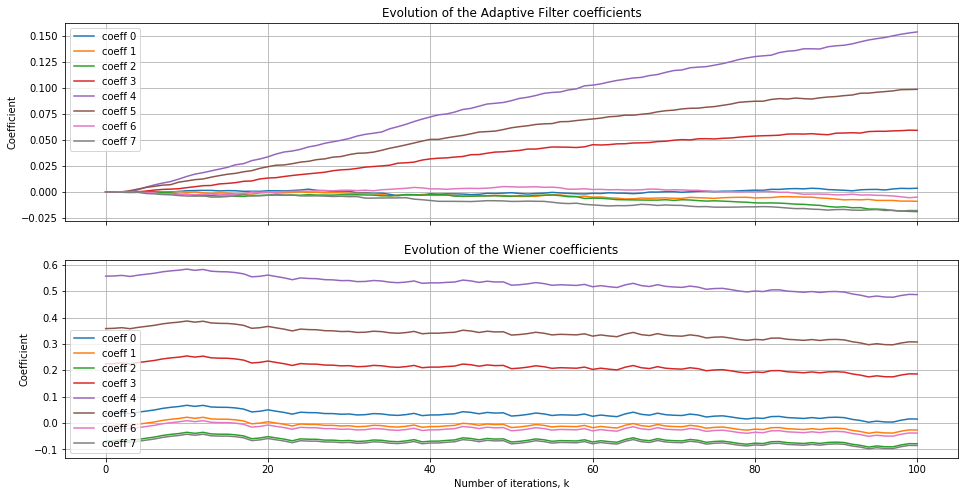

In [83]:
def plot_problem_16(K, N, MSE_av, MSEmin_av, MSEexc_av, W_av, w_o, output_filepath=None, algorithm='LMS'):
    # Generating Learning Curve plots 
    fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(16,8), sharex=True)
    ax[0].plot(np.arange(K), MSE_av)
    ax[0].set_title('Learning Curve for MSE')
    ax[0].set_ylabel('MSE')
    ax[0].grid(True)

    ax[1].plot(np.arange(K), MSEmin_av)
    ax[1].set_title('Learning Curve for MSEmin')
    ax[1].set_ylabel('MSEmin')    
    ax[1].grid(True)
    
    ax[2].plot(np.arange(K), MSEexc_av)
    ax[2].set_title('Learning Curve for MSEexc')
    ax[2].set_ylabel('MSEexc')
    ax[2].set_xlabel('Number of iterations, k') 
    ax[2].grid(True)

    if output_filepath is not None:
        # Creating plots output folder if they don't exist
        if not os.path.exists(output_filepath):
            os.makedirs(output_filepath)
        fig.savefig(output_filepath + algorithm + '_learning_curve.jpg', bbox_inches = 'tight')

    # Generating Evolution of Coefficients plots
    fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16,8), sharex=True)
    for n in np.arange(N):
        ax[0].plot(np.arange(K+1), np.real(W_av[:,n]), label='coeff {}'.format(str(n)))
    ax[0].set_title('Evolution of the Adaptive Filter coefficients')
    ax[0].set_ylabel('Coefficient')
    ax[0].grid(True)
    ax[0].legend(loc='upper left')

    for n in np.arange(N):
        ax[1].plot(np.arange(K+1), np.real(W_o_av[:,n]), label='coeff {}'.format(str(n)))    
    ax[1].set_title('Evolution of the Wiener coefficients')
    ax[1].set_ylabel('Coefficient')
    ax[1].set_xlabel('Number of iterations, k') 
    ax[1].grid(True)
    ax[1].legend(loc='lower left')
    
    if output_filepath is not None:        
        fig.savefig(output_filepath + algorithm + '_coef_evolution.jpg', bbox_inches = 'tight')

    plt.show()
    
plot_problem_16(K, N, MSE_av, MSEmin_av, MSEexc_av, W_av, w_o, output_filepath=output_filepath, algorithm='16_LMS_mu'+str(mu).replace('.', ''))

### (b) Repeat (a) for $\mu = 0.01$

### (c) Repeat (a) for $\mu_{opt}$.

$\mu_{opt} = \sqrt{\frac{(N+1)\sigma_w^2}{4\sigma_n^2tr[R]}}$

________
## Exercise 26

In [54]:
## Definitions
n_ensembles = 20   # number of realizations within the ensemble
K = 100             # number of iterations (signal length)
H = np.array([0.32+0.21j,-0.3+0.7j,0.5-0.8j,0.2+0.5j])    
w_o = H             # Unknown system
sigma_n2 = .4      # noise power
N = 4               # Number of coefficients of the adaptive filter
mu = .1            # Convergence factor (step) (0 < mu < 1)
output_filepath = './Outputs/Exercise_26/'


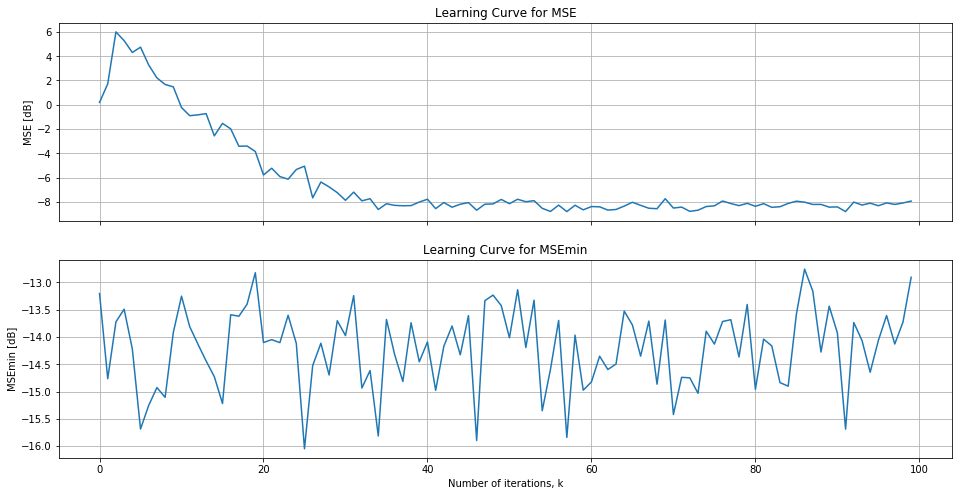

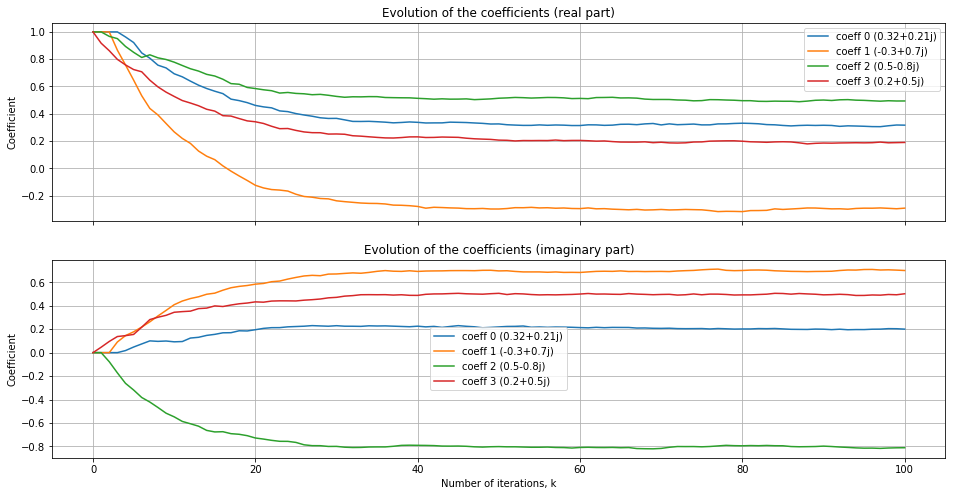

In [55]:
## Definitions
j = complex(0,1)
n_ensembles = 20   # number of realizations within the ensemble
K = 100             # number of iterations (signal length)
H = np.array([0.32+0.21j,-0.3+0.7j,0.5-0.8j,0.2+0.5j])    
w_o = H             # Unknown system
sigma_n2 = .04      # noise power
N = 4               # Number of coefficients of the adaptive filter
mu = .1            # Convergence factor (step) (0 < mu < 1)

## Computing 

# coefficient vector for each iteration and realization, w[0] = [1, 1, ..., 1]
W = np.ones([n_ensembles, K+1, N], dtype=complex) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles, K]) # Minimum MSE for each realization 

for ensemble in np.arange(n_ensembles):    
    d = np.zeros([K], dtype=complex) # Desired signal

    # Creating the input signal (normalized)        
    x = (np.sign(np.random.randn(K)) + j*np.sign(np.random.randn(K)))/np.sqrt(2) # Complex signal
    n = np.sqrt(sigma_n2/2)*(np.random.normal(size=K)+j*np.random.normal(size=K)) # Complex noise
    sigma_x2 = np.var(x) # signal power = 1

    # Creating a tapped version of x with a N-sized window 
    prefixed_x = np.append(np.zeros([N-1]), x)
    X_tapped = rolling_window(prefixed_x, N)

    for k in np.arange(K):        
        d[k] = np.dot(np.conj(w_o), X_tapped[k])+n[k]       

    init_coef = W[ensemble][0]
    filter_order = N-1    

    lms = LMS(step=mu, filter_order=filter_order, init_coef=init_coef)
    lms.fit(d, x)     

    W[ensemble] = lms.coef_vector
    MSE[ensemble] = MSE[ensemble] + np.absolute(lms.error_vector)**2
    MSE_min[ensemble] = MSE_min[ensemble] + np.absolute(n)**2

W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles

# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, w_o, output_filepath=output_filepath, algorithm='LMS')

In [ ]:
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles

# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, w_o, output_filepath=output_filepath, algorithm='LMS')